In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import json

In [3]:
fid = open('usagov_bitly_data2013-05-16-1368695937', 'rb')

In [4]:
records = [json.loads(line) for line in fid]

In [5]:
records[0]

{u'a': u'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.31 (KHTML, like Gecko) Chrome/26.0.1410.64 Safari/537.31',
 u'al': u'en-US,en;q=0.8',
 u'c': u'US',
 u'cy': u'Whittier',
 u'g': u'16hIfSr',
 u'gr': u'CA',
 u'h': u'16hIfSq',
 u'hc': 1368661734,
 u'hh': u'1.usa.gov',
 u'l': u'o_4og9tq48m3',
 u'll': [33.945702, -118.038803],
 u'nk': 0,
 u'r': u'https://www.facebook.com/',
 u't': 1368695936,
 u'tz': u'America/Los_Angeles',
 u'u': u'http://www.jpl.nasa.gov/spaceimages/details.php?id=PIA15817'}

In [6]:
frame = pd.DataFrame(records)

In [7]:
# Count timezones
tz_counts = frame['tz'].value_counts()

In [8]:
tz_counts[:10]

                       404
America/New_York       269
America/Chicago        118
Europe/London          105
America/Los_Angeles    102
Europe/Prague           71
Australia/NSW           45
Asia/Calcutta           37
Asia/Tokyo              35
Europe/Berlin           30
dtype: int64

In [9]:
clean_tz = frame['tz'].fillna('Missing')
clean_tz[clean_tz == '']='Unknown'

In [10]:
tz_counts = clean_tz.value_counts()

In [11]:
tz_counts[:10]

Unknown                404
America/New_York       269
Missing                120
America/Chicago        118
Europe/London          105
America/Los_Angeles    102
Europe/Prague           71
Australia/NSW           45
Asia/Calcutta           37
Asia/Tokyo              35
dtype: int64

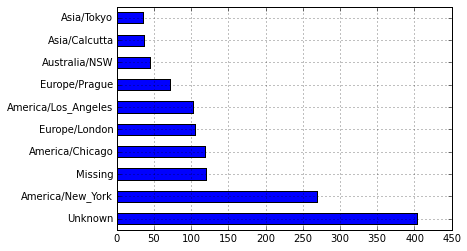

In [12]:
#Plot most common timezones
tz_counts[:10].plot(kind='barh', rot=0)

In [13]:
# Fields in frame
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1797 entries, 0 to 1796
Data columns (total 18 columns):
_heartbeat_    120 non-null float64
a              1677 non-null object
al             1458 non-null object
c              1291 non-null object
cy             1291 non-null object
g              1677 non-null object
gr             1291 non-null object
h              1677 non-null object
hc             1677 non-null float64
hh             1677 non-null object
kw             23 non-null object
l              1677 non-null object
ll             1276 non-null object
nk             1677 non-null float64
r              1677 non-null object
t              1677 non-null float64
tz             1677 non-null object
u              1677 non-null object
dtypes: float64(4), object(14)
memory usage: 266.7+ KB


In [14]:
frame['a'][1].split()

[u'Opera/9.80',
 u'(Windows',
 u'Mobile;',
 u'Opera',
 u'Mini/5.1.21595/29.3530;',
 u'U;',
 u'en)',
 u'Presto/2.8.119',
 u'Version/11.10']

In [15]:
# 'a' column is user agent as space separated fields, ignore spaces between brackets
import re

In [16]:
results = pd.Series([re.findall('\([^)]*\)|\S+',obs)[0] for obs in frame.a.dropna()])

In [17]:
results.value_counts()[:10]

Mozilla/5.0           1283
Mozilla/4.0            216
Opera/9.80              50
TVersity                42
Socialite/7845          19
Dalvik/1.6.0            17
CakePHP                  9
Yes                      7
Kml-Google;              6
ShortLinkTranslate       5
dtype: int64

In [18]:
# Cleaned frame where each row has an agent string
cframe = frame.loc[frame['a'].notnull(), :]

In [19]:
#cframe.loc[cframe['tz'].isnull(), 'tz'] = 'Missing'

In [20]:
#cframe.loc[cframe['tz'] == '', 'tz'] = 'Unknown'

In [21]:
# Partition into Windows and Non Windows
operating_system = np.where(cframe['a'].str.contains('Windows'), 'Windows', 'Not Windows')

In [22]:
# Decompose timezones into Windows and Non Windows
## TODO: need to learn how groupby objects work
by_tz_os = cframe.groupby(['tz', operating_system])

In [23]:
agg_counts = by_tz_os.size().unstack().fillna(0)

In [24]:
agg_counts[:10]

,Not Windows,Windows
tz,,
,208,196
Africa/Abidjan,0,1
Africa/Accra,1,0
Africa/Blantyre,0,1
Africa/Cairo,0,1
Africa/Gaborone,0,1
Africa/Johannesburg,4,8
Africa/Kampala,0,2
Africa/Lagos,3,0


In [25]:
# Sort in ascending order by summing total for each timezone then using argsort to return indexes in sorted array
indexer = agg_counts.sum(1).argsort()

In [26]:
indexer[:10]

tz
                       102
Africa/Abidjan          21
Africa/Accra            88
Africa/Blantyre         87
Africa/Cairo            24
Africa/Gaborone         50
Africa/Johannesburg     26
Africa/Kampala          20
Africa/Lagos            30
America/Anchorage       33
dtype: int64

In [27]:
# Since we've sorted in ascending order the last 10 elements are the most common 10
count_subset = agg_counts.take(indexer)[-10:]

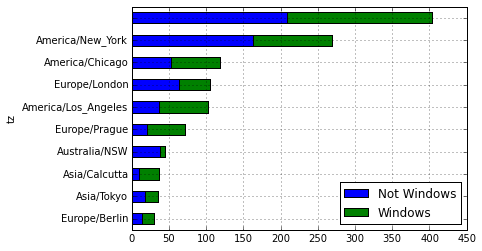

In [28]:
count_subset.plot(kind='barh', stacked=True)

In [29]:
# Normalize by total count in each timezone
normed_subset = count_subset.div(count_subset.sum(1), axis=0)

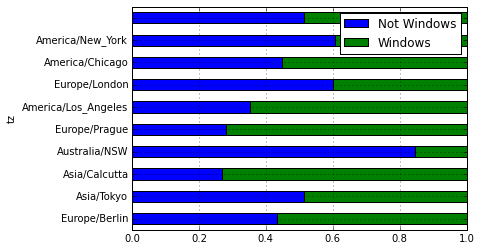

In [30]:
normed_subset.plot(kind='barh', stacked=True)